In [86]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from src.modules import conf, fit, spec, evl, pred, preprocess
import seaborn as sns
import matplotlib.pyplot as plt
from src.heuristics import random_shooting
from src.heuristics import genetic_optimization

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
%matplotlib inline
sns.set(style='ticks')
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [55]:
data = fit.load_pcls(
        conf["Athlete"]["name"],
        conf["Athlete"]["activity_type"],
        conf["Paths"]["pcl"],
    )

100%|██████████| 361/361 [00:00<00:00, 973.13it/s] 


In [56]:
r_cross = conf['GO']['r_cross']
r_mut = conf['GO']['r_mut']
ban_cols=['heart_rate','cadence','enhanced_speed']

In [57]:
train_df, test_df = fit.get_train_test_df(data,ratio=0.7)
test_df, valid_df = fit.get_test_valid_df(test_df)
print(len(train_df),len(test_df),len(valid_df))

valid_df = data[fit.get_race_index(data, '2022-10-08-11-18')]
speed = valid_df.enhanced_speed
hr = valid_df.heart_rate
cad = valid_df.cadence

182943 103870 6449


In [58]:
replace_act = data[fit.get_race_index(data, '2022-10-02-10-30')]

In [63]:
for x in valid_df.columns:
    if not all([False if y in x else True for y in ban_cols]):
        valid_df.drop(x,axis=1,inplace=True)

In [65]:
len(valid_df),len(replace_act)

(5653, 4413)

In [88]:
valid_df['heart_rate'] = np.mean(replace_act.heart_rate)
valid_df['cadence'] = np.mean(replace_act.cadence)
valid_df['log_heart_rate'] = np.log(valid_df.heart_rate)
valid_df['sin_heart_rate'] = np.sin(valid_df.heart_rate)
valid_df['cos_heart_rate'] = np.cos(valid_df.heart_rate)
valid_df['tan_heart_rate'] = np.tan(valid_df.heart_rate)
valid_df['diff_heart_rate'] = (valid_df.heart_rate).diff()
valid_df['log_cadence'] = np.log(valid_df.cadence)
valid_df['sin_cadence'] = np.sin(valid_df.cadence)
valid_df['cos_cadence'] = np.cos(valid_df.cadence)
valid_df['tan_cadence'] = np.tan(valid_df.cadence)
valid_df['diff_cadence'] = valid_df.cadence.diff()
valid_df['cadence_delayed'] = preprocess.calc_delayed(valid_df.cadence)
valid_df['log_cadence_delayed'] = np.log(valid_df.cadence_delayed)
valid_df['sin_cadence_delayed'] = np.sin(valid_df.cadence_delayed)
valid_df['cos_cadence_delayed'] = np.cos(valid_df.cadence_delayed)
valid_df['tan_cadence_delayed'] = np.tan(valid_df.cadence_delayed)
valid_df['diff_cadence_delayed'] = valid_df.cadence_delayed.diff()

In [78]:
_,_,rmse,cols, nrmse = random_shooting.random_shoot(
                          train_df=train_df,
                          test_df=test_df,
                          hmax=30,
                          endog='enhanced_speed',
                          )
np.min(rmse)

100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


1.6760532239694557

In [80]:
full_cols = [x for x in train_df.columns if 'enhanced_speed' not in x]
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(3, r_cross,r_mut ,sorted_cols,train_df,test_df,full_cols,'enhanced_speed')

 67%|██████▋   | 2/3 [01:17<00:40, 40.10s/it]

New best: 1.672495874648806
New best: 1.6665672176537856


100%|██████████| 3/3 [02:03<00:00, 41.31s/it]

New best: 1.6542024278310004


In [89]:
form = random_shooting.get_form(list(best),endog='enhanced_speed')
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
print(evl.rmse(speed,pred_ols))

2.8261042646687087


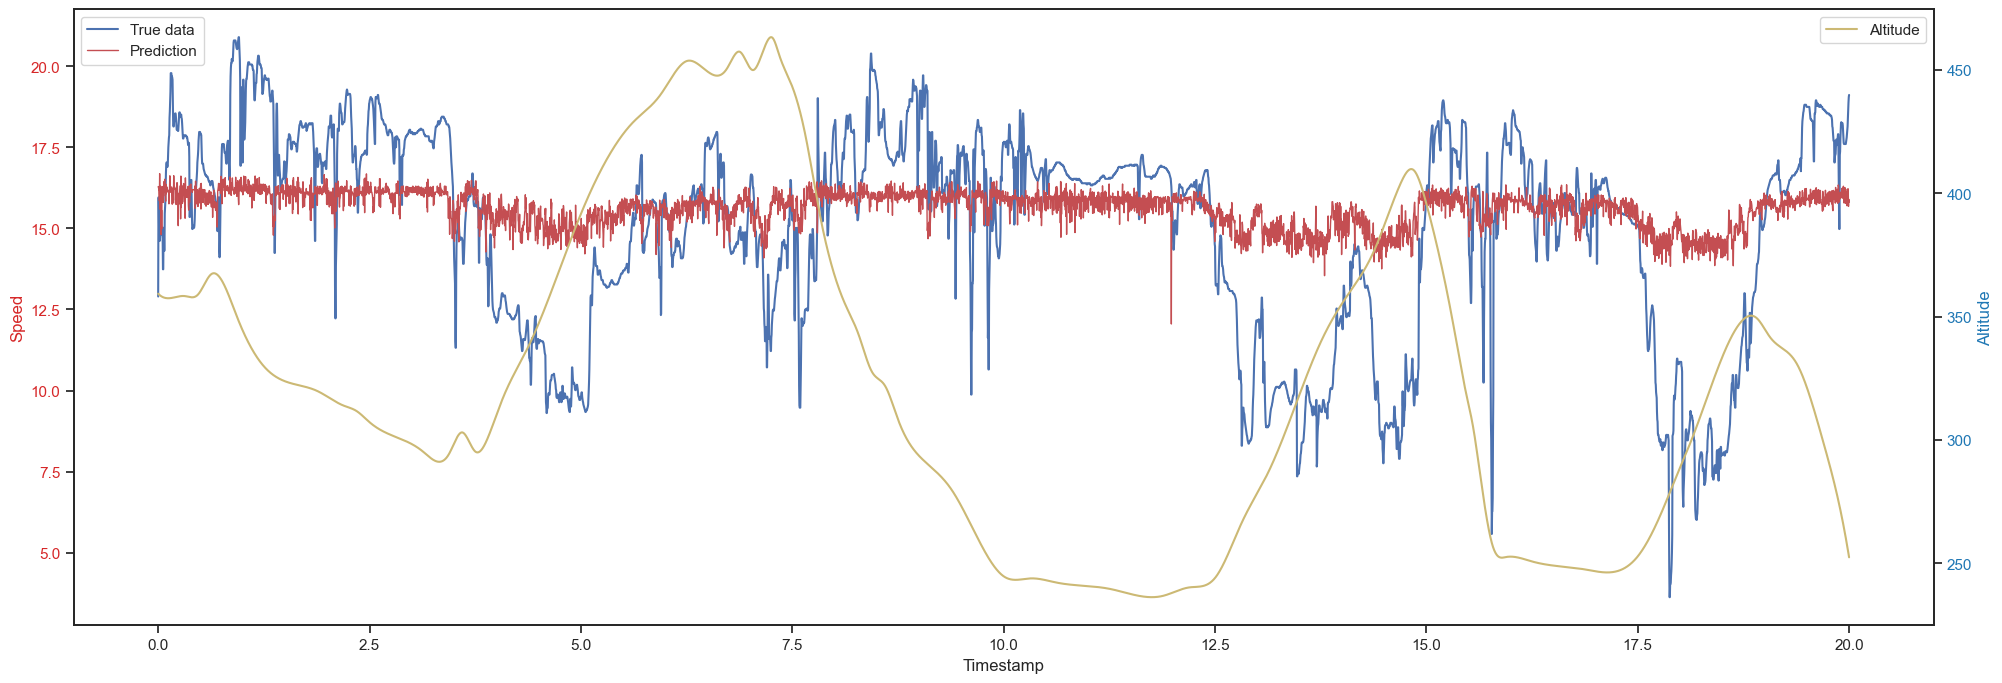

In [90]:
fig = evl.plot(df=valid_df,pred=pred_ols,endog='enhanced_speed',true_data=speed)